# Practical: Deep Semantic Segmentation and Video Object Segmentation

### Learning Objectives:

* Understand how semantic segmentation is performed using convolutional neural networks.
* Get to know the literature in deep semantic segmentation.
* Understand how to incorporate context.
* Understand video object segmentation with a simple example method.
* Understand few-shot segmentation with a simple eample method.
* Try hands on examples with PyTorch.

# Fully Convolutional Networks:
---


![alt text](https://raw.githubusercontent.com/MSiam/DLIndabaX/master/images/fcn.png) 

*   Don't forget to select GPU from menus: Runtime->Change runtime type
*   To set breakpoints: from pdb import set_trace; set_trace(), and use exit() to exit

Now we will see the pytorch code for FCN and try it out. We start with imports necessary:

In [0]:
import torch.nn as nn                                                                                                                                                                                                                  
import torch.nn.functional as F
import torch
import numpy as np
import cv2
from collections import OrderedDict
import matplotlib.pyplot as plt   
from torchvision import transforms

Then in order to construct FCN we create the necessary layers

In [0]:
class fcn(nn.Module):
    def __init__(self, n_classes=21):
        super(fcn, self).__init__()
        self.n_classes = n_classes

        # Encoder: Feature Extraction VGG-16
        self.create_encoder()
        
        # Decoder
        self.classifier = nn.Sequential(
            nn.Conv2d(512, 256, 1),
            nn.ReLU(inplace=True),
            nn.Dropout2d(),
            nn.Conv2d(256, self.n_classes, 1),
        )
        
    # Creates a VGG16 backbone
    def create_encoder(self):
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2, ceil_mode=True),
        )   
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2, ceil_mode=True),
        )   
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(inplace=True),                                                                                                                                                                                                     
            nn.MaxPool2d(2, stride=2, ceil_mode=True),
        )   
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(inplace=True), 
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(2, stride=2, ceil_mode=True),
        )   
        self.conv_block5 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(inplace=True), 
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(2, stride=2, ceil_mode=True),
        )   
    # Forward method
    def forward(self, x):
        # Extract Features
        conv1 = self.conv_block1(x)
        conv2 = self.conv_block2(conv1)
        conv3 = self.conv_block3(conv2)
        conv4 = self.conv_block4(conv3)
        conv5 = self.conv_block5(conv4)
        
        # Compute probability maps
        score = self.classifier(conv5)
        out = F.upsample(score, x.size()[2:])
        return out, score.detach()

Example code to load weights, preprocess an image, infer through the network and compute its semantic segmentation output.

In [7]:
# Download sample image
!curl --header 'Host: doc-0g-b8-docs.googleusercontent.com' --user-agent 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:66.0) Gecko/20100101 Firefox/66.0' --header 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8' --header 'Accept-Language: en-US,en;q=0.5' --referer 'https://drive.google.com/' --cookie 'AUTH_ke38de5om415qdl9mh10ijp9ovprni2j_nonce=fgm44nu47vtio' --header 'Upgrade-Insecure-Requests: 1' 'https://doc-0g-b8-docs.googleusercontent.com/docs/securesc/2n3g1c92fvum2ti2873eohe2s5i599l8/0s4snbn7jgdp9mh4h5am2ultei3jcal0/1556748000000/11397432307160908430/11397432307160908430/1moDlgQTnrDzoXwfXqMKh-qEFSxNHdWzI?e=download&h=04295518330385903249&nonce=fgm44nu47vtio&user=11397432307160908430&hash=aoe93medoneunq4kq9f4548aoeu9ghhs' --output '2007_000027.jpg'

# Download weights
!curl --header 'Host: doc-10-b8-docs.googleusercontent.com' --user-agent 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:66.0) Gecko/20100101 Firefox/66.0' --header 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8' --header 'Accept-Language: en-US,en;q=0.5' --referer 'https://drive.google.com/drive/u/0/folders/1D3rmR2mjgKLnRT0nh7vu-39Idtks8l5H' --cookie 'AUTH_ke38de5om415qdl9mh10ijp9ovprni2j=11397432307160908430|1556748000000|oovusi3ngmlfqihrrq5q0ocnaonr8pbh' --header 'Upgrade-Insecure-Requests: 1' 'https://doc-10-b8-docs.googleusercontent.com/docs/securesc/2n3g1c92fvum2ti2873eohe2s5i599l8/jpsolh27cpude3t1b2sbs25hecobaope/1556748000000/11397432307160908430/11397432307160908430/1sqXlRKlhrF7ojaOWh_mCBRbJUIPhYxkq?h=04295518330385903249&e=download' --output 'fcn32s_pascal_best_model.pkl'


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  142k  100  142k    0     0   599k      0 --:--:-- --:--:-- --:--:--  602k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  113M    0  113M    0     0  60.6M      0 --:--:--  0:00:01 --:--:-- 60.5M


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


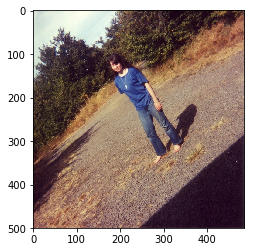

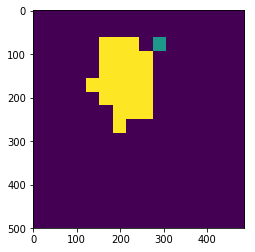

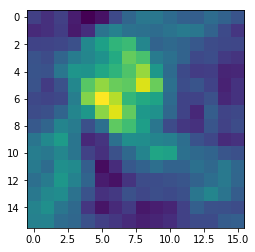

In [18]:
'''
Transforms the input numpy array to torch tensor and performs normalization
'''
def transform(img):
    tf = transforms.Compose([transforms.ToTensor(),
                             transforms.Normalize([0.485, 0.456, 0.406],
                                                  [0.229, 0.224, 0.225])])
        

    img = tf(img)
    return img               

'''
Creates dictionary of weights works with saved torch.nn.DataParallel
'''
def convert_state_dict(state_dict):
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[7:]  # remove `module.`
        new_state_dict[name] = v  
    return new_state_dict
    

model = fcn()

# Load Weights
device = torch.device("cuda")
state = convert_state_dict(torch.load('fcn32s_pascal_best_model.pkl')['model_state'])
model.load_state_dict(state)
model.eval()
model.to(device)

# Load Image
img = cv2.imread('2007_000027.jpg')
original_img = img.copy()
img = transform(img).unsqueeze(0)
img = img.to(device)

# Infer on img
outputs, hmaps = model(img)
pred = outputs.data.max(1)[1].cpu().numpy()
hmaps = hmaps.cpu().numpy()

pascal_lbls = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
               'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
               'person', 'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

# Visualize Prediction
plt.figure(2);plt.imshow(original_img[:,:,::-1]);

crct_cls = pascal_lbls.index('person')
plt.figure(1);plt.imshow(pred[0]);
plt.figure(3);plt.imshow(hmaps[0, crct_cls, ...]);plt.show()


**Loss Function:**
We see here the code for bootstrapped cross entropy loss that would be used for training. 
However we won't go through the details for the training code. 

For a good repo in pytorch that has both training and evaluation code you can refer to this repo:
https://github.com/meetshah1995/pytorch-semseg

In [0]:
def bootstrapped_cross_entropy2d(input,
                                  target,
                                  K,
                                  weight=None,
                                  size_average=True):
    batch_size = input.size()[0]
    def _bootstrap_xentropy_single(input,
                                   target,
                                   K,
                                   weight=None,
                                   size_average=True):

        n, c, h, w = input.size()
        input = input.transpose(1, 2).transpose(2, 3).contiguous().view(-1, c)
        target = target.view(-1)
        loss = F.cross_entropy(input,
                               target,
                               weight=weight,
                               reduce=False,
                               size_average=False,
                               ignore_index=250)
        topk_loss, _ = loss.topk(K)
        reduced_topk_loss = topk_loss.sum() / K

        return reduced_topk_loss

    loss = 0.0
    # Bootstrap from each image not entire batch
    for i in range(batch_size):
        loss += _bootstrap_xentropy_single(
            input=torch.unsqueeze(input[i], 0),
            target=torch.unsqueeze(target[i], 0),
            K=K,
            weight=weight,
            size_average=size_average,
        )
    return loss / float(batch_size)


# Upsampling within the network:

---

![alt text](https://raw.githubusercontent.com/MSiam/DLIndabaX/master/images/fcn8s.png) 



The output heatmaps as you saw is a downsampled version due to multiple pooling layers (5 pooling layers in VGG-16). 

* We use skip connections to improve the segmentation accuracy. Following FCN8s architecture. 
     - FCN32s: 32 stride means the output will be input_size / 32
     - FCN8s: stands for 8 stride means output will be input_size / 8

* One way is to upsample the heatmap using bilinear interpolation during inference, and train with downsampled version of the labels. In some scenarios that would work but in others it can degrade your accuracy. That was what we did in the previous code.

* A better way is to learn the upsampling within the network using a layer called **Transposed Convolution**. Some use the term deconvolution or back-strided convolution for the same thing. Instead of fixed parameters make it learnable.

* **Stride is the upsampling factor, why?**
    - In a **regular convolution** output size is:
          O = (W - F + 2P)/S + 1
    - In **Transposed Convolution**:
          O = W * S + F
          
    - W: input image width
    - O: output image width
    - F: filter size
    - P: padding
    - S: stride

In [0]:
class fcn8s(fcn):                                                                                                                                                                                                                      
    def __init__(self, n_classes=21, transconv=False):
        super(fcn8s, self).__init__()
        self.transconv = transconv
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=100),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2, ceil_mode=True),
        )
    
        # Decoder
        self.fconv_block = nn.Sequential(
            nn.Conv2d(512, 4096, 7),
            nn.ReLU(inplace=True),
            nn.Dropout2d(),
            nn.Conv2d(4096, 4096, 1),
            nn.ReLU(inplace=True),
            nn.Dropout2d(),
            nn.Conv2d(4096, 256, 1),
        )
        # I am setting bias to False for reasons that will be clarified in Few-Shot Seg
        self.classifier = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Dropout2d(),
            nn.Conv2d(256, self.n_classes, 1, bias=False),
        )
        
        # Layers responsible for skip connection
        self.score_pool4 = nn.Conv2d(512, self.n_classes, 1, bias=False)
        self.score_pool3 = nn.Conv2d(256, self.n_classes, 1, bias=False)
        
        # Create transposed convolution layers
        if self.transconv: 
                  self.upscore2 = nn.ConvTranspose2d(self.n_classes, self.n_classes, 4,
                                                     stride=2, bias=False)
                  self.upscore4 = nn.ConvTranspose2d(self.n_classes, self.n_classes, 4,
                                                     stride=2, bias=False)
                  self.upscore8 = nn.ConvTranspose2d(self.n_classes, self.n_classes, 16,
                                               stride=8, bias=False)
    def forward(self, x): 
        # Extract Features
        conv1 = self.conv_block1(x)
        conv2 = self.conv_block2(conv1)        
        conv3 = self.conv_block3(conv2)        
        conv4 = self.conv_block4(conv3)
        conv5 = self.conv_block5(conv4)
        fconv = self.fconv_block(conv5)
        
        # Compute probability maps
        score = self.classifier(fconv)
        score_pool4 = self.score_pool4(conv4)
        score_pool3 = self.score_pool3(conv3)
        scores = [score.detach(), score_pool4.detach(),
                  score_pool3.detach()]
        
        if not self.transconv:
            score = F.upsample(score, score_pool4.size()[2:])
            score += score_pool4
            score = F.upsample(score, score_pool3.size()[2:])
            score += score_pool3
            out = F.upsample(score, x.size()[2:])
        else:
            upscore2 = self.upscore2(score)
            score_pool4c = self.score_pool4(conv4)[:, :, 5:5+upscore2.size()[2],
                                                         5:5+upscore2.size()[3]]
            upscore_pool4 = self.upscore4(upscore2 + score_pool4c)
        
            score_pool3c = self.score_pool3(conv3)[:, :, 9:9+upscore_pool4.size()[2],
                                                         9:9+upscore_pool4.size()[3]]
                                
            out = self.upscore8(score_pool3c + upscore_pool4)[:, :, 31:31+x.size()[2],                                                                                                                                                 
                                                                    31:31+x.size()[3]]
        return out, scores 

* One problem with transposed convolution is **checkerboard effect**.



* One way to go around that is perform bilinear upsampling followed by a convolutional layer. Thus combining both the effect of learning the weights end-to-end while avoiding the checkerboard effect.

More details in [1].

<sup>[1] https://distill.pub/2016/deconv-checkerboard/</sup>

Inference Code

In [0]:
model = fcn8s(transconv=False)

# Load Weights
device = torch.device("cuda")
state = convert_state_dict(torch.load('fcn8s_pascal_best_model.pkl')['model_state'])
model.load_state_dict(state)
model.eval()
model.to(device)

# Load Image
img = cv2.imread('2007_000027.jpg')
original_img = img.copy()
img = transform(img).unsqueeze(0)
img = img.to(device)

# Infer on img
outputs, hmaps = model(img)
pred = outputs.data.max(1)[1].cpu().numpy()

# Visualize Prediction
plt.figure(2);plt.imshow(original_img[:,:,::-1]);
plt.figure(1);plt.imshow(pred[0]);plt.show()

# DeepLab
---

The code for deeplab model using resnet feature extracter and Atrous Spatial Pyramid pooling

![alt text](https://raw.githubusercontent.com/MSiam/DLIndabaX/master/images/deeplab_aspp.jpg) 

In [0]:
import torch.nn as nn                                                                                                                                                                                                                  
import math
import torch.utils.model_zoo as model_zoo
import torch
import numpy as np
affine_par = True
def outS(i):
    i = int(i)
    i = (i+1)/2                 
    i = int(np.ceil((i+1)/2.0))
    i = (i+1)/2
    return int(i)
def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)
    

class BasicBlock(nn.Module):
    expansion = 1
        
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes, affine = affine_par)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes, affine = affine_par)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
    
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
    
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        
        out += residual
        out = self.relu(out)
        
        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1,  dilation_ = 1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, bias=False) # change
        self.bn1 = nn.BatchNorm2d(planes,affine = affine_par)
        for i in self.bn1.parameters():
            i.requires_grad = False
        padding = 1
        if dilation_ == 2:
            padding = 2
        elif dilation_ == 4:
            padding = 4
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, # change
                               padding=padding, bias=False, dilation = dilation_)
        self.bn2 = nn.BatchNorm2d(planes,affine = affine_par)
        for i in self.bn2.parameters():
            i.requires_grad = False
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4, affine = affine_par)
        for i in self.bn3.parameters():
            i.requires_grad = False
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        
    def forward(self, x): 
        residual = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        
        if self.downsample is not None:
            residual = self.downsample(x)
        
        out += residual
        out = self.relu(out)
        
        return out

class Classifier_Module(nn.Module):

    def __init__(self,dilation_series,padding_series,NoLabels):
        super(Classifier_Module, self).__init__()
        self.conv2d_list = nn.ModuleList()
        for dilation,padding in zip(dilation_series,padding_series):
            self.conv2d_list.append(nn.Conv2d(2048,NoLabels,kernel_size=3,stride=1, padding =padding, dilation = dilation,bias = True))
    
        for m in self.conv2d_list:
            m.weight.data.normal_(0, 0.01)
        
        
    def forward(self, x):
        out = self.conv2d_list[0](x)
        for i in range(len(self.conv2d_list)-1):
            out += self.conv2d_list[i+1](x)
        return out

class ResNet(nn.Module):       
    def __init__(self, block, layers,NoLabels):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64,affine = affine_par)
        for i in self.bn1.parameters():
            i.requires_grad = False
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, ceil_mode=True) # change
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=1, dilation__ = 2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=1, dilation__ = 4)
        self.layer5 = self._make_pred_layer(Classifier_Module, [6,12,18,24],[6,12,18,24],NoLabels)
            
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, 0.01)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        #        for i in m.parameters():
        #            i.requires_grad = False
        
    def _make_layer(self, block, planes, blocks, stride=1,dilation__ = 1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion or dilation__ == 2 or dilation__ == 4:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False), 
                nn.BatchNorm2d(planes * block.expansion,affine = affine_par),
            )
        for i in downsample._modules['1'].parameters():
            i.requires_grad = False
        layers = []       
        layers.append(block(self.inplanes, planes, stride,dilation_=dilation__, downsample = downsample ))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes,dilation_=dilation__))
        
        return nn.Sequential(*layers)
    def _make_pred_layer(self,block, dilation_series, padding_series,NoLabels):
        return block(dilation_series,padding_series,NoLabels)
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        
        return x

DeepLab Model itself

In [0]:
class MS_Deeplab(nn.Module):
    def __init__(self,block,NoLabels):
        super(MS_Deeplab,self).__init__()
        self.Scale = ResNet(block,[3, 4, 23, 3],NoLabels)   #changed to fix #4
    
    def forward(self,x):
        input_size = x.size()[2]
        self.interp1 = nn.UpsamplingBilinear2d(size = (  int(input_size*0.75)+1,  int(input_size*0.75)+1  ))
        self.interp2 = nn.UpsamplingBilinear2d(size = (  int(input_size*0.5)+1,   int(input_size*0.5)+1   ))
        self.interp3 = nn.UpsamplingBilinear2d(size = (  outS(input_size),   outS(input_size)   ))
        out = []
        x2 = self.interp1(x)
        x3 = self.interp2(x)
        out.append(self.Scale(x))       # for original scale
        out.append(self.interp3(self.Scale(x2)))        # for 0.75x scale
        out.append(self.Scale(x3))      # for 0.5x scale
        
        
        x2Out_interp = out[1]
        x3Out_interp = self.interp3(out[2])
        temp1 = torch.max(out[0],x2Out_interp)
        out.append(torch.max(temp1,x3Out_interp))
        return out
        
def Res_Deeplab(NoLabels=21):
    model = MS_Deeplab(Bottleneck,NoLabels)
    return model

Infererring through Deeplab

In [0]:
import scipy                                                                                                                                                                                                                           
from scipy import ndimage
import cv2
import numpy as np
import sys
import torch
from torch.autograd import Variable
import torchvision.models as models
import torch.nn.functional as F
import deeplab_resnet
from collections import OrderedDict
import os
from os import walk
import matplotlib.pyplot as plt
import torch.nn as nn

gpu0 = 0
im_path = '../samples/2007_000032.jpg'
model = deeplab_resnet.Res_Deeplab(int(args['--NoLabels']))
model.eval()
counter = 0
model.cuda(gpu0)                                                                                                                                                                                                                       
snapPrefix = 'MS_DeepLab_resnet_trained_VOC.pth'

saved_state_dict = torch.load(snapPrefix)

saved_state_dict = torch.load(snapPrefix)
counter+=1
model.load_state_dict(saved_state_dict)

img = np.zeros((513,513,3));

img_temp = cv2.imread(im_path).astype(float)
img_original = img_temp
img_temp[:,:,0] = img_temp[:,:,0] - 104.008
img_temp[:,:,1] = img_temp[:,:,1] - 116.669
img_temp[:,:,2] = img_temp[:,:,2] - 122.675
img[:img_temp.shape[0],:img_temp.shape[1],:] = img_temp
output = model(Variable(torch.from_numpy(img[np.newaxis, :].transpose(0,3,1,2)).float(),volatile = True).cuda(gpu0))
interp = nn.UpsamplingBilinear2d(size=(513, 513))
output = interp(output[3]).cpu().data[0].numpy()
output = output[:,:img_temp.shape[0],:img_temp.shape[1]]

output = output.transpose(1,2,0)
output = np.argmax(output,axis = 2)

plt.figure(1); plt.imshow(img_original)
plt.figure(2); plt.imshow(output)
plt.show()

# Few-shot Segmentation:

---

Now lets tryout to segment a new class with only one labelled image provided for that new class.

1-shot 1-way segmentation scenario

![alt text](https://raw.githubusercontent.com/MSiam/DLIndabaX/master/images/adapproxy.png) 

In [0]:
import torch.nn as nn                                                                                                                                                                                                                  
import torch.nn.functional as F
import torch
import numpy as np
import cv2
from collections import OrderedDict
import matplotlib.pyplot as plt
from torchvision import transforms
import sys

In [0]:
class imprint_fcn8s(fcn):
    def __init__(self, n_classes=21):
        super(imprint_fcn8s, self).__init__(n_classes=n_classes)
                
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, dilation=2, padding=2),
            nn.ReLU(inplace=True), 
        )   
            
        self.conv_block5 = nn.Sequential(
            nn.Conv2d(512, 512, 3, dilation=2, padding=2),
            nn.ReLU(inplace=True), 
            nn.Conv2d(512, 512, 3, dilation=4, padding=4),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, dilation=4, padding=4),
            nn.ReLU(inplace=True),                                                                                                                                                                                                     
        )
        # Decoder
        self.fconv_block = nn.Sequential(nn.Conv2d(512, 256, 1))
        self.classifier = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Dropout2d(),
            nn.Conv2d(256, self.n_classes, 1, bias=False),
        )
        self.score_pool4 = nn.Conv2d(512, self.n_classes, 1, bias=False)
        self.score_pool3 = nn.Conv2d(256, self.n_classes, 1, bias=False)
            
    def forward(self, x):
        # Extract Features 
        conv1 = self.conv_block1(x)
        conv2 = self.conv_block2(conv1)
        conv3 = self.conv_block3(conv2)
        conv4 = self.conv_block4(conv3)
        conv5 = self.conv_block5(conv4)
        fconv = self.fconv_block(conv5)
        
        # Compute probability maps
        score = self.classifier(fconv)
        score_pool4 = self.score_pool4(conv4)
        score_pool3 = self.score_pool3(conv3)
        
        score = F.upsample(score, score_pool4.size()[2:])
        score += score_pool4
        score = F.upsample(score, score_pool3.size()[2:])
        score += score_pool3
        out = F.upsample(score, x.size()[2:])
        
        return out

    def extract(self, x, label):
        conv1 = self.conv_block1(x)
        conv2 = self.conv_block2(conv1)
        conv3 = self.conv_block3(conv2)
        conv4 = self.conv_block4(conv3)
        conv5 = self.conv_block5(conv4)
        fconv = self.fconv_block(conv5)
        
        fconv_pooled = masked_embeddings(fconv.shape, label, fconv,
                                         self.n_classes)
        conv3_pooled = masked_embeddings(conv3.shape, label, conv3,
                                         self.n_classes)
        conv4_pooled = masked_embeddings(conv4.shape, label, conv4,
                                         self.n_classes)
                                         
        return fconv_pooled, conv4_pooled, conv3_pooled
      
    def imprint(self, images, labels, alpha):
        with torch.no_grad():            
            embeddings = None            
            for ii, ll in zip(images, labels):
                #ii = ii.unsqueeze(0)    
                ll = ll[0]
                if embeddings is None:   
                    embeddings, early_embeddings, vearly_embeddings = self.extract(ii, ll)
                else:
                    embeddings_, early_embeddings_, vearly_embeddings_ = self.extract(ii, ll)
                    embeddings = torch.cat((embeddings, embeddings_), 0)
                    early_embeddings = torch.cat((early_embeddings, early_embeddings_), 0)
                    vearly_embeddings = torch.cat((vearly_embeddings, vearly_embeddings_), 0)
                
            # Imprint weights for last score layer
            nclasses = self.n_classes
            self.n_classes = 17
            nchannels = embeddings.shape[2]
                
            weight = compute_weight(embeddings, nclasses, labels,
                                         self.classifier[2].weight.data, alpha=alpha)
            self.classifier[2] = nn.Conv2d(nchannels, self.n_classes, 1, bias=False)
            self.classifier[2].weight.data = weight
                
            weight4 = compute_weight(early_embeddings, nclasses, labels,
                                     self.score_pool4.weight.data, alpha=alpha)
            self.score_pool4 = nn.Conv2d(512, self.n_classes, 1, bias=False)
            self.score_pool4.weight.data = weight4
                
            weight3 = compute_weight(vearly_embeddings, nclasses, labels,
                                     self.score_pool3.weight.data, alpha=alpha)
            self.score_pool3 = nn.Conv2d(256, self.n_classes, 1, bias=False)
            self.score_pool3.weight.data = weight3
                
            assert self.classifier[2].weight.is_cuda
            assert self.score_pool3.weight.is_cuda
            assert self.score_pool4.weight.is_cuda
            assert self.score_pool3.weight.data.shape[1] == 256                                                                                                                                                                        
            assert self.classifier[2].weight.data.shape[1] == 256
            assert self.score_pool4.weight.data.shape[1] == 512


NameError: ignored

In [0]:
def compute_weight(embeddings, nclasses, labels, original_weight, alpha):
    imp_weight = embeddings.mean(0).squeeze()
            
    # Add imprinted weights for -ve samples that occurred in support image
    for c in range(nclasses):
        if len(labels[labels==c]) != 0:
            temp = original_weight[c, ...].squeeze()
            temp = (1-alpha)*temp + alpha*imp_weight[c].cuda()
            temp = temp / temp.norm(p=2)
            original_weight[c, ...] = temp.unsqueeze(1).unsqueeze(1)
    
    # Add imprinted weights for + sample (last class)
    imp_weight[-1] = imp_weight[-1] / imp_weight[-1].norm(p=2)
    imp_weight = imp_weight[-1].unsqueeze(0).unsqueeze(2).unsqueeze(3)
    weight = torch.cat((original_weight, imp_weight.cuda()), 0)
    return weight
                                      
def compute_weight(embeddings, nclasses, labels, original_weight, alpha):
    imp_weight = embeddings.mean(0).squeeze()
            
    # Add imprinted weights for -ve samples that occurred in support image
    for c in range(nclasses):
        if len(labels[labels==c]) != 0:
            temp = original_weight[c, ...].squeeze()
            temp = (1-alpha)*temp + alpha*imp_weight[c].cuda()
            temp = temp / temp.norm(p=2)
            original_weight[c, ...] = temp.unsqueeze(1).unsqueeze(1)
    
    # Add imprinted weights for + sample (last class)
    imp_weight[-1] = imp_weight[-1] / imp_weight[-1].norm(p=2)
    imp_weight = imp_weight[-1].unsqueeze(0).unsqueeze(2).unsqueeze(3)
    weight = torch.cat((original_weight, imp_weight.cuda()), 0)
    return weight

In [0]:
model = imprint_fcn8s(n_classes=16)

# Load Weights
device = torch.device("cuda")
state = convert_state_dict(torch.load('../weights/dilated_fcn8s_fold0/dilated_fcn8s_pascal_best_model.pkl')['model_state'])
model.load_state_dict(state)
model.eval()
model.to(device)

# Load Image
sprt_img = cv2.imread('../samples/sprt_img.png')
sprt_lbl = cv2.imread('../samples/sprt_gt.png', 0)

img = cv2.imread('../samples/qry_img.png')
original_img = img.copy()
original_sprt = sprt_img.copy()
original_gt = sprt_lbl.copy()

img = transform(img).unsqueeze(0)
img = img.to(device)

sprt_img = transform(sprt_img).unsqueeze(0)
sprt_img = sprt_img.to(device)

sprt_lbl = torch.from_numpy(np.array(sprt_lbl)).long()
sprt_lbl[sprt_lbl == 255] = 0
sprt_lbl = sprt_lbl.to(device).unsqueeze(0)

# Infer on img
model.imprint([sprt_img], [sprt_lbl], alpha=0.25821)
outputs = model(img)
pred = outputs.data.max(1)[1].cpu().numpy()

pascal_lbls = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
               'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
               'person', 'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

# Visualize Prediction
plt.figure(2);plt.imshow(original_img[:,:,::-1]);
plt.figure(3);plt.imshow(original_sprt[:,:,::-1]);
plt.figure(4);plt.imshow(original_gt)
plt.figure(1);plt.imshow(pred[0]);plt.show()


# Video Object Segmentation (Two-stream FCN8s):

---

We have talked about FusionSeg as one architecture that combines motion and appearance for video object segmentation.

![alt text](https://feedforward.github.io/blog/assets/img/dfsadfsfsf.png) 

We will start building a simpler one using the same FCN8s architecture but while creating a motion stream and an appearance stream.

In [0]:
import torch.nn as nn                                                                                                                                                                                                                  
import torch.nn.functional as F
import torch
import numpy as np
import cv2
from collections import OrderedDict
import matplotlib.pyplot as plt
from torchvision import transforms
import sys

Separate encoder code to create one for both motion and appearance.

In [0]:
def create_encoder(self):
        conv_block1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2, ceil_mode=True),
        )
        conv_block2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2, ceil_mode=True),
        )
        conv_block3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2, ceil_mode=True),
        )
        conv_block4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(inplace=True), 
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(2, stride=2, ceil_mode=True),
        )   
        conv_block5 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(inplace=True), 
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(2, stride=2, ceil_mode=True),
        )   
        encoder = nn.Sequential(conv_block1,
                                conv_block2,
                                conv_block3,
                                conv_block4,                                                                                                                                                                                           
                                conv_block5)
        return encoder


In [0]:
   def forward(self, x, flo):  
        # Extract Features      
        mot_feats = self.mot_encoder(flo)
        app_feats = self.app_encoder(x)
        feats = mot_feats * app_feats
    
        # Compute probability maps
        fconv = self.fconv_block(feats)
        score = self.classifier(fconv)
        
        out = F.upsample(score, x.size()[2:])
        out = self.upscore(out)
        return out


Inference Code

In [0]:
model = twostreamfcn8s(n_classes=2)

# Load Weights
device = torch.device("cuda")
state = convert_state_dict(torch.load('../weights/fcn8s/fcn8s_pascal_best_model.pkl')['model_state'])
model.load_state_dict(state)
model.eval()
model.to(device)

# Load Image and optical flow
img = cv2.imread('../samples/blackswan/00000.jpg')
flow = cv2.imread('../samples/blackswan_of/00000.jpg')

original_img = img.copy()
original_flow = flow.copy()

img = transform(img).unsqueeze(0)
img = img.to(device)

flow = transform(flow).unsqueeze(0)
flow = flow.to(device)


# Infer on img
outputs, hmaps = model(img, flow)
pred = outputs.data.max(1)[1].cpu().numpy()

# Visualize Prediction
plt.figure(3);plt.imshow(original_img[:,:,::-1]);
plt.figure(2);plt.imshow(original_flow[:,:,::-1]);
plt.figure(1);plt.imshow(pred[0]);plt.show()
